In [43]:
from __future__ import print_function, division
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
import requests
from io import BytesIO
import dlib
from numpy import asarray
import os.path
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import dlib
import os
import argparse

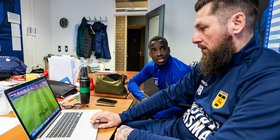

In [133]:
urls = ['https://images2.persgroep.net/rcs/MKddFc-N7DUGurfPhDdqQRjSqNo/diocontent/211823231/_fit/500/400?appId=c66748603e84b2e1a9bbfcdd8de0f671',
       "https://images0.persgroep.net/rcs/ivTpKVc2V_XGz1yT_VQudueLCG0/diocontent/180351536/_fit/500/400?appId=c66748603e84b2e1a9bbfcdd8de0f671",
        "https://images0.persgroep.net/rcs/xkiDi4GwyijxeOYsO3pzbtjIm4Y/diocontent/212477697/_crop/674/747/4936/2468/_fill/280/140?appId=93a17a8fd81db0de025c8abd1cca1279&quality=0.85"]

# images = []
response = requests.get(urls[0])
img_1 = Image.open(BytesIO(response.content))
array_1 = img_to_array(img_1).astype('uint8')

response = requests.get(urls[1])
img_2 = Image.open(BytesIO(response.content))
array_2 = asarray(img_2)

response = requests.get(urls[2])
img_3 = Image.open(BytesIO(response.content))

img_3

In [114]:
def detect_face(image_paths, default_max_size=800,size = 300, padding = 0.25):
    cnn_face_detector = dlib.cnn_face_detection_model_v1('mmod_human_face_detector.dat')
    sp = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')
    base = 2000  # largest width and height
    for index, img_path in enumerate(image_paths):
        if index % 1000 == 0:
            print('---%d/%d---' %(index, len(image_paths)))

        response = requests.get(img_path)
        img = Image.open(BytesIO(response.content))
        img = asarray(img)
        
        old_height, old_width, _ = img.shape
        if old_width > old_height:
            new_width, new_height = default_max_size, int(default_max_size * old_height / old_width)
        else:
            new_width, new_height =  int(default_max_size * old_width / old_height), default_max_size
        img = dlib.resize_image(img, rows=new_height, cols=new_width)

        dets = cnn_face_detector(img, 1)
        num_faces = len(dets)
        if num_faces == 0:
            print("Sorry, there were no faces found in '{}'".format(image_path))
            continue
        # Find the 5 face landmarks we need to do the alignment.
        faces = dlib.full_object_detections()
        for detection in dets:
            rect = detection.rect
            faces.append(sp(img, rect))
        images = dlib.get_face_chips(img, faces, size=size, padding = padding)

        for idx, image in enumerate(images):
            img_name = 'img_' + str(index) + '_face_' + str(idx) + '.jpeg'
#             face_name = str(idx) + img_name
#             path_sp = img_name.split(".")
#             face_name = os.path.join(SAVE_DETECTED_AT,  path_sp[0] + "_" + "face" + str(idx) + "." + path_sp[-1])
            dlib.save_image(image, 'faces/' + img_name)

# detect_face(urls)

In [129]:
def predict_age_gender_race(save_prediction_at, imgs_path = 'faces/'):
    
    model = 'res34_fair_align_multi_7_20190809.pt' #'fairface_alldata_20191111.pt'
    img_names = [os.path.join(imgs_path, x) for x in os.listdir(imgs_path) if x.endswith('jpeg')] 
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model_fair_7 = torchvision.models.resnet34(pretrained=True)
    model_fair_7.fc = nn.Linear(model_fair_7.fc.in_features, 18)
    map_location=torch.device('cpu')
    model_fair_7.load_state_dict(torch.load(model, map_location=map_location))
    model_fair_7 = model_fair_7.to(device)
    model_fair_7.eval()

#     model_fair_4 = torchvision.models.resnet34(pretrained=True)
#     model_fair_4.fc = nn.Linear(model_fair_4.fc.in_features, 18)
#     model_fair_4.load_state_dict(torch.load('fair_face_models/fairface_alldata_4race_20191111.pt'))
#     model_fair_4 = model_fair_4.to(device)
#     model_fair_4.eval()

    trans = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    # img pth of face images
    face_names = []
    # list within a list. Each sublist contains scores for all races. Take max for predicted race
    race_scores_fair = []
    gender_scores_fair = []
    age_scores_fair = []
    race_preds_fair = []
    gender_preds_fair = []
    age_preds_fair = []
#     race_scores_fair_4 = []
#     race_preds_fair_4 = []

    for index, img_name in enumerate([img for img in img_names if img.endswith('jpeg')]):
#         print(img_name)
#         if index % 1000 == 0:
#             print("Predicting... {}/{}".format(index, len(img_names)))

        face_names.append(img_name)
        image = dlib.load_rgb_image(img_name)
        image = trans(image)
        image = image.view(1, 3, 224, 224)  # reshape image to match model dimensions (1 batch size)
        image = image.to(device)

        # fair
        outputs = model_fair_7(image)
        outputs = outputs.cpu().detach().numpy()
        outputs = np.squeeze(outputs)

        race_outputs = outputs[:7]
        gender_outputs = outputs[7:9]
        age_outputs = outputs[9:18]

        race_score = np.exp(race_outputs) / np.sum(np.exp(race_outputs))
        gender_score = np.exp(gender_outputs) / np.sum(np.exp(gender_outputs))
        age_score = np.exp(age_outputs) / np.sum(np.exp(age_outputs))

        race_pred = np.argmax(race_score)
        gender_pred = np.argmax(gender_score)
        age_pred = np.argmax(age_score)

        race_scores_fair.append(race_score)
        gender_scores_fair.append(gender_score)
        age_scores_fair.append(age_score)

        race_preds_fair.append(race_pred)
        gender_preds_fair.append(gender_pred)
        age_preds_fair.append(age_pred)

#         # fair 4 class
#         outputs = model_fair_4(image)
#         outputs = outputs.cpu().detach().numpy()
#         outputs = np.squeeze(outputs)

#         race_outputs = outputs[:4]
#         race_score = np.exp(race_outputs) / np.sum(np.exp(race_outputs))
#         race_pred = np.argmax(race_score)

#         race_scores_fair_4.append(race_score)
#         race_preds_fair_4.append(race_pred)

    result = pd.DataFrame([face_names,
                           race_preds_fair,
#                            race_preds_fair_4,
                           gender_preds_fair,
                           age_preds_fair,
                           race_scores_fair, #race_scores_fair_4,
                           gender_scores_fair,
                           age_scores_fair, ]).T
    result.columns = ['face_name_align',
                      'race_preds_fair',
#                       'race_preds_fair_4',
                      'gender_preds_fair',
                      'age_preds_fair',
                      'race_scores_fair',
#                       'race_scores_fair_4',
                      'gender_scores_fair',
                      'age_scores_fair']
    result.loc[result['race_preds_fair'] == 0, 'race'] = 'White'
    result.loc[result['race_preds_fair'] == 1, 'race'] = 'Black'
    result.loc[result['race_preds_fair'] == 2, 'race'] = 'Latino_Hispanic'
    result.loc[result['race_preds_fair'] == 3, 'race'] = 'East Asian'
    result.loc[result['race_preds_fair'] == 4, 'race'] = 'Southeast Asian'
    result.loc[result['race_preds_fair'] == 5, 'race'] = 'Indian'
    result.loc[result['race_preds_fair'] == 6, 'race'] = 'Middle Eastern'

#     # race fair 4

#     result.loc[result['race_preds_fair_4'] == 0, 'race4'] = 'White'
#     result.loc[result['race_preds_fair_4'] == 1, 'race4'] = 'Black'
#     result.loc[result['race_preds_fair_4'] == 2, 'race4'] = 'Asian'
#     result.loc[result['race_preds_fair_4'] == 3, 'race4'] = 'Indian'

    # gender
    result.loc[result['gender_preds_fair'] == 0, 'gender'] = 'Male'
    result.loc[result['gender_preds_fair'] == 1, 'gender'] = 'Female'

    # age
    result.loc[result['age_preds_fair'] == 0, 'age'] = '0-2'
    result.loc[result['age_preds_fair'] == 1, 'age'] = '3-9'
    result.loc[result['age_preds_fair'] == 2, 'age'] = '10-19'
    result.loc[result['age_preds_fair'] == 3, 'age'] = '20-29'
    result.loc[result['age_preds_fair'] == 4, 'age'] = '30-39'
    result.loc[result['age_preds_fair'] == 5, 'age'] = '40-49'
    result.loc[result['age_preds_fair'] == 6, 'age'] = '50-59'
    result.loc[result['age_preds_fair'] == 7, 'age'] = '60-69'
    result.loc[result['age_preds_fair'] == 8, 'age'] = '70+'

#     result[['face_name_align',
#             'race', 
# #             'race4',
#             'gender', 'age',
# #             'race_scores_fair', 
# #             'race_scores_fair_4',
# #             'gender_scores_fair', 
# #             'age_scores_fair'
#            ]].to_csv(save_prediction_at, index=False)

#     print("saved results at ", save_prediction_at)

    return result['race', 'gender', 'age']

In [130]:
urls = ["https://media-exp1.licdn.com/dms/image/C4D03AQH3v3_VIvA8CA/profile-displayphoto-shrink_800_800/0/1587480559787?e=1650499200&v=beta&t=neSa1pKP9RHBDffJlnvTDf8g2suVwDsw0s89kvBDld8",
       "https://www.dub.uu.nl/sites/default/files/users/1172/images/Thomas-Boeschoten-Credits-Sebastiaan-ter-Burg.jpg"]

# parser = argparse.ArgumentParser()
# parser.add_argument('--csv', dest='input_csv', action='store',
#                     help='csv file of image path where col name for image path is "img_path')
dlib.DLIB_USE_CUDA = True
print("using CUDA?: %s" % dlib.DLIB_USE_CUDA)
# args = parser.parse_args()
# SAVE_DETECTED_AT = "detected_faces"
# ensure_dir(SAVE_DETECTED_AT)
# imgs = pd.read_csv(args.input_csv)['img_path']
# detect_face(urls)

# print("detected faces are saved at ", SAVE_DETECTED_AT)
# # Please change test_outputs.csv to actual name of output csv. 


predict_age_gender_race('test_output_csv', 'faces/')


using CUDA?: True
faces/img_0_face_0.jpeg
Predicting... 0/4
faces/img_2_face_0.jpeg
faces/img_2_face_1.jpeg
faces/img_1_face_0.jpeg


,face_name_align,race_preds_fair,gender_preds_fair,age_preds_fair,race_scores_fair,gender_scores_fair,age_scores_fair,race,gender,age
0,faces/img_0_face_0.jpeg,0,1,3,"[0.62038946, 5.1722567e-05, 0.013987578, 0.000...","[3.5200508e-06, 0.9999965]","[2.4072527e-08, 0.00021000509, 0.2388693, 0.73...",White,Female,20-29
1,faces/img_2_face_0.jpeg,1,0,3,"[3.2208103e-05, 0.9992872, 0.00021515066, 2.29...","[0.99693656, 0.0030634124]","[3.6503202e-06, 0.0009033183, 0.07185564, 0.57...",Black,Male,20-29
2,faces/img_2_face_1.jpeg,0,0,5,"[0.62315977, 0.004195669, 0.0035048784, 5.4876...","[0.9924027, 0.0075973165]","[2.2461636e-05, 3.9603365e-05, 0.0003424527, 0...",White,Male,40-49
3,faces/img_1_face_0.jpeg,0,0,3,"[0.99363697, 8.636716e-06, 0.0022908903, 0.001...","[0.9996343, 0.00036570273]","[2.641825e-06, 6.947645e-05, 0.056703344, 0.67...",White,Male,20-29


In [106]:
urls = ["https://media-exp1.licdn.com/dms/image/C4D03AQH3v3_VIvA8CA/profile-displayphoto-shrink_800_800/0/1587480559787?e=1650499200&v=beta&t=neSa1pKP9RHBDffJlnvTDf8g2suVwDsw0s89kvBDld8",
       "https://www.dub.uu.nl/sites/default/files/users/1172/images/Thomas-Boeschoten-Credits-Sebastiaan-ter-Burg.jpg"]


# detect_face(urls, 'faces/')
predict_age_gender_race('test_output_csv')



Predicting... 0/5


RuntimeError: Unknown image file format: Unable to load image in file faces/.ipynb_checkpoints

In [149]:
url = "https://images0.persgroep.net/rcs/xkiDi4GwyijxeOYsO3pzbtjIm4Y/diocontent/212477697/_crop/674/747/4936/2468/_fill/280/140?appId=93a17a8fd81db0de025c8abd1cca1279&quality=0.85"

def detect_face(url, default_max_size=800,size = 300, padding = 0.25):
    cnn_face_detector = dlib.cnn_face_detection_model_v1('mmod_human_face_detector.dat')
    sp = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')
    base = 2000  # largest width and height
    
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = asarray(img)

    old_height, old_width, _ = img.shape
    if old_width > old_height:
        new_width, new_height = default_max_size, int(default_max_size * old_height / old_width)
    else:
        new_width, new_height =  int(default_max_size * old_width / old_height), default_max_size
    img = dlib.resize_image(img, rows=new_height, cols=new_width)

    dets = cnn_face_detector(img, 1)
    num_faces = len(dets)
    if num_faces == 0:
        return []
    # Find the 5 face landmarks we need to do the alignment.
    faces = dlib.full_object_detections()
    for detection in dets:
        rect = detection.rect
        faces.append(sp(img, rect))
    faces = dlib.get_face_chips(img, faces, size=size, padding = padding)

#     for idx, image in enumerate(images):
#         img_name = 'img_' + str(index) + '_face_' + str(idx) + '.jpeg'
# #             face_name = str(idx) + img_name
# #             path_sp = img_name.split(".")
# #             face_name = os.path.join(SAVE_DETECTED_AT,  path_sp[0] + "_" + "face" + str(idx) + "." + path_sp[-1])
#         dlib.save_image(image, 'faces/' + img_name)
    
    return faces

detect_face(url)


[array([[[ 56,  54,  43],
         [ 59,  56,  47],
         [ 61,  59,  50],
         ...,
         [182, 187, 185],
         [181, 187, 184],
         [181, 187, 184]],
 
        [[ 57,  55,  45],
         [ 59,  57,  48],
         [ 62,  60,  51],
         ...,
         [182, 188, 185],
         [182, 187, 185],
         [181, 187, 184]],
 
        [[ 58,  55,  46],
         [ 60,  58,  49],
         [ 62,  61,  52],
         ...,
         [183, 188, 185],
         [182, 188, 185],
         [182, 188, 184]],
 
        ...,
 
        [[  1,  20, 115],
         [  1,  20, 115],
         [  0,  19, 114],
         ...,
         [  2,  41, 157],
         [  2,  41, 158],
         [  1,  41, 158]],
 
        [[  1,  20, 115],
         [  1,  20, 114],
         [  1,  19, 114],
         ...,
         [  2,  40, 157],
         [  1,  41, 158],
         [  1,  41, 159]],
 
        [[  1,  20, 114],
         [  1,  19, 114],
         [  1,  19, 113],
         ...,
         [  1,  40, 157],
  

In [176]:
def predict_age_gender_race(url):
    
    model = 'res34_fair_align_multi_7_20190809.pt' 
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model_fair_7 = torchvision.models.resnet34(pretrained=True)
    model_fair_7.fc = nn.Linear(model_fair_7.fc.in_features, 18)
    map_location=torch.device('cpu')
    model_fair_7.load_state_dict(torch.load(model, map_location=map_location))
    model_fair_7 = model_fair_7.to(device)
    model_fair_7.eval()

    trans = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    race_preds_fair = []
    gender_preds_fair = []
    age_preds_fair = []

    faces = detect_face(url)
    if len(faces) == 0:
        return pd.DataFrame(columns=['race', 'gender', 'age'], dtype=object)
    for face in faces:
        
        image = trans(face)
        image = image.view(1, 3, 224, 224)  # reshape image to match model dimensions (1 batch size)
        image = image.to(device)

        # fair
        outputs = model_fair_7(image)
        outputs = outputs.cpu().detach().numpy()
        outputs = np.squeeze(outputs)
        
        race_outputs = outputs[:7]
        gender_outputs = outputs[7:9]
        age_outputs = outputs[9:18]
        
        race_score = np.exp(race_outputs) / np.sum(np.exp(race_outputs))
        gender_score = np.exp(gender_outputs) / np.sum(np.exp(gender_outputs))
        age_score = np.exp(age_outputs) / np.sum(np.exp(age_outputs))

        race_pred = np.argmax(race_score)
        gender_pred = np.argmax(gender_score)
        age_pred = np.argmax(age_score)

        race_preds_fair.append(race_pred)
        gender_preds_fair.append(gender_pred)
        age_preds_fair.append(age_pred)
    
    result = pd.DataFrame([race_preds_fair,
                           gender_preds_fair,
                           age_preds_fair,
                           ]).T
    
    result.columns = ['race_preds_fair',
                      'gender_preds_fair',
                      'age_preds_fair']
    
    result.loc[result['race_preds_fair'] == 0, 'race'] = 'White'
    result.loc[result['race_preds_fair'] == 1, 'race'] = 'Black'
    result.loc[result['race_preds_fair'] == 2, 'race'] = 'Latino_Hispanic'
    result.loc[result['race_preds_fair'] == 3, 'race'] = 'East Asian'
    result.loc[result['race_preds_fair'] == 4, 'race'] = 'Southeast Asian'
    result.loc[result['race_preds_fair'] == 5, 'race'] = 'Indian'
    result.loc[result['race_preds_fair'] == 6, 'race'] = 'Middle Eastern'

    # gender
    result.loc[result['gender_preds_fair'] == 0, 'gender'] = 'Male'
    result.loc[result['gender_preds_fair'] == 1, 'gender'] = 'Female'

    # age
    result.loc[result['age_preds_fair'] <= 1, 'age'] = '0-9'
    result.loc[result['age_preds_fair'] == 2, 'age'] = '10-19'
    result.loc[result['age_preds_fair'] == 3, 'age'] = '20-29'
    result.loc[result['age_preds_fair'] == 4, 'age'] = '30-39'
    result.loc[result['age_preds_fair'] == 5, 'age'] = '40-49'
    result.loc[result['age_preds_fair'] == 6, 'age'] = '50-59'
    result.loc[result['age_preds_fair'] == 7, 'age'] = '60-69'
    result.loc[result['age_preds_fair'] == 8, 'age'] = '70+'

    return result[['race', 'gender', 'age']]

In [178]:
url = "https://www.pewresearch.org/wp-content/uploads/2020/06/FT_20.06.29_AsianAmericans_feature-1.png"

result = predict_age_gender_race(url)